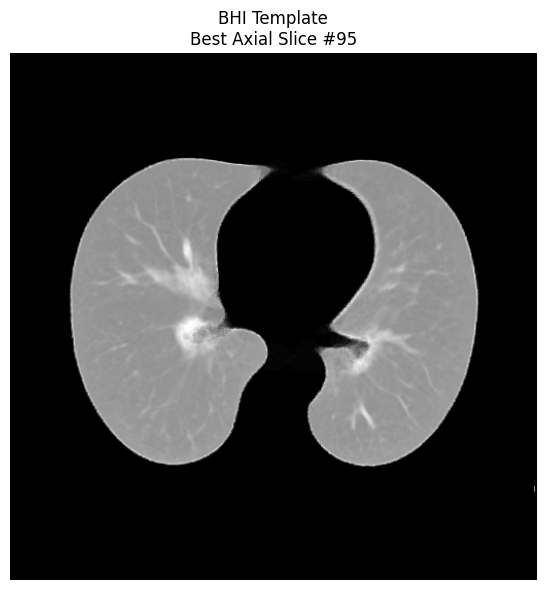

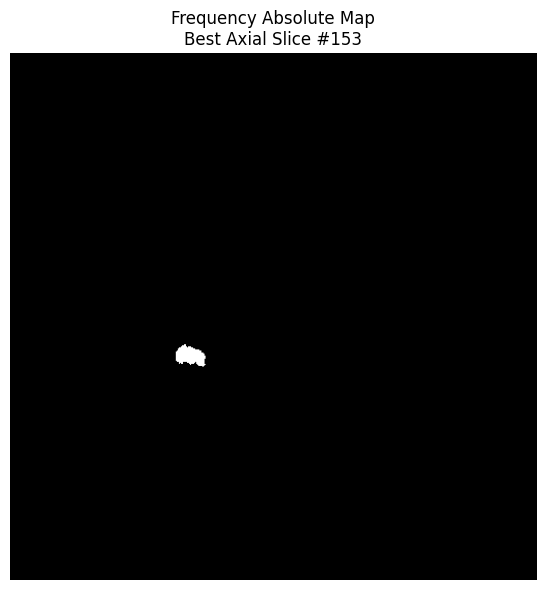

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import os

bhi_path = "/content/BHI_template.nii"
freq_path = "/content/frequency_absolute_map.nii"

def flip_to_RAS(image):
    RAS = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
    if image.GetDirection() == RAS:
        return image
    else:
        flip_axes = [False, False, False]
        for i in (0, 4, 8):
            if image.GetDirection()[i] < 0:
                flip_axes[i // 3] = True
        return sitk.Flip(image, flip_axes)

def best_axial_slice(image):
    arr = sitk.GetArrayFromImage(image)
    variances = [np.var(slice_) for slice_ in arr]
    best_idx = int(np.argmax(variances))
    return best_idx, arr[best_idx, :, :]

def show_best_slice(image_path, title):
    img = sitk.ReadImage(image_path)
    img = flip_to_RAS(img)
    best_idx, slice_data = best_axial_slice(img)
    plt.figure(figsize=(6, 6))
    plt.imshow(slice_data, cmap='gray')
    plt.title(f"{title}\nBest Axial Slice #{best_idx}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

show_best_slice(bhi_path, "BHI Template")
show_best_slice(freq_path, "Frequency Absolute Map")




📂 Loading: /content/BHI_template.nii


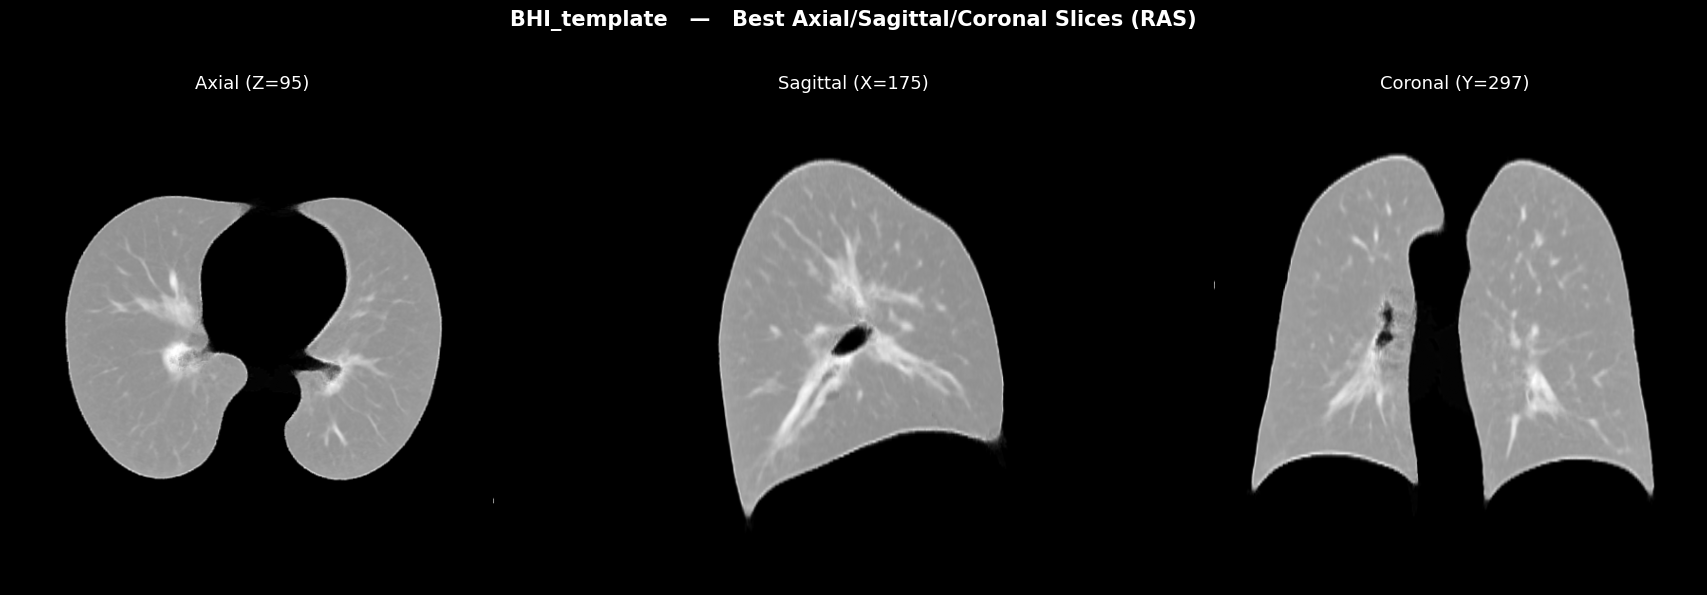

💾 Saved: /content/output/BHI_template_best3views_RAS.png

📂 Loading: /content/frequency_absolute_map.nii


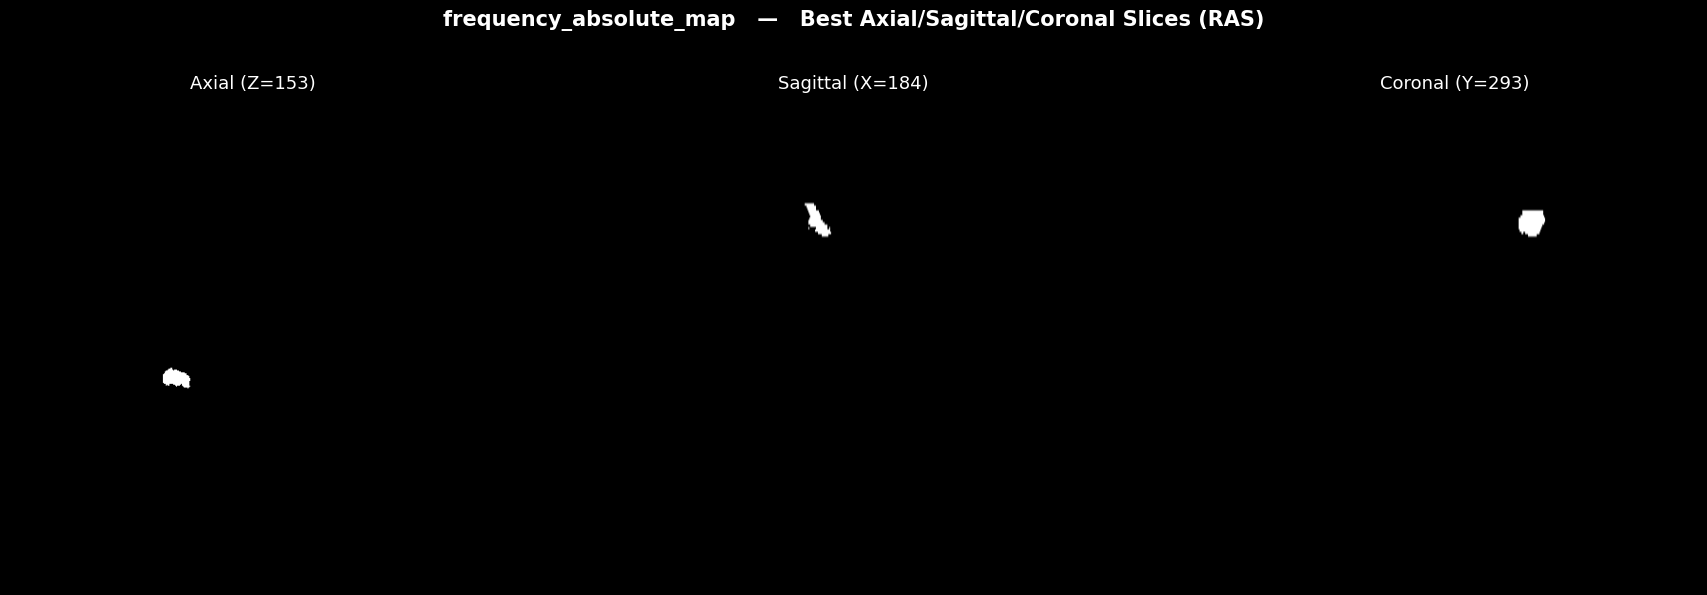

💾 Saved: /content/output/frequency_absolute_map_best3views_RAS.png


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import SimpleITK as sitk
import os

nii_files = [
    "/content/BHI_template.nii",
    "/content/frequency_absolute_map.nii"
]

output_dir = "/content/output"
os.makedirs(output_dir, exist_ok=True)

def flip_to_RAS(image):
    RAS = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
    if image.GetDirection() == RAS:
        return image
    flip_axes = [False, False, False]
    for i in (0, 4, 8):
        if image.GetDirection()[i] < 0:
            flip_axes[i // 3] = True
    return sitk.Flip(image, flip_axes)

def best_slice_by_variance(arr, axis):
    variances = []
    num_slices = arr.shape[axis]
    for i in range(num_slices):
        if axis == 0:
            slc = arr[i, :, :]
        elif axis == 1:
            slc = arr[:, i, :]
        else:
            slc = arr[:, :, i]
        variances.append(np.var(slc))
    best_idx = int(np.argmax(variances))
    return best_idx

def plot_best_three_views(img, image_name):
    arr = sitk.GetArrayFromImage(img)
    best_z = best_slice_by_variance(arr, axis=0)
    best_y = best_slice_by_variance(arr, axis=1)
    best_x = best_slice_by_variance(arr, axis=2)
    axial_slice = arr[best_z, :, :]
    sagittal_slice = arr[:, :, best_x]
    coronal_slice = arr[:, best_y, :]
    sagittal_slice = np.flipud(np.fliplr(sagittal_slice))
    coronal_slice = np.flipud(np.fliplr(coronal_slice))
    ref_shape = axial_slice.shape
    sagittal_resized = resize(sagittal_slice, ref_shape, anti_aliasing=True)
    coronal_resized = resize(coronal_slice, ref_shape, anti_aliasing=True)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.patch.set_facecolor('black')
    titles = [
        f"Axial (Z={best_z})",
        f"Sagittal (X={best_x})",
        f"Coronal (Y={best_y})"
    ]
    slices = [axial_slice, sagittal_resized, coronal_resized]
    for ax, slc, title in zip(axes, slices, titles):
        ax.imshow(slc, cmap='gray')
        ax.set_title(title, fontsize=13, color='white', pad=8)
        ax.axis('off')
    plt.tight_layout(pad=0.5)
    plt.subplots_adjust(top=0.82, wspace=0.03, hspace=0.02)
    fig.text(
        0.5, 0.97,
        f"{image_name}   —   Best Axial/Sagittal/Coronal Slices (RAS)",
        color='white',
        fontsize=15,
        ha='center',
        va='top',
        fontweight='bold'
    )
    output_path = os.path.join(output_dir, f"{image_name}_best3views_RAS.png")
    plt.savefig(output_path, bbox_inches='tight', dpi=200, facecolor=fig.get_facecolor())
    plt.show()
    plt.close(fig)
    print(f"💾 Saved: {output_path}")

for path in nii_files:
    print(f"\n📂 Loading: {path}")
    image_name = os.path.basename(path).replace(".nii", "")
    img = sitk.ReadImage(path)
    flipped = flip_to_RAS(img)
    plot_best_three_views(flipped, image_name)


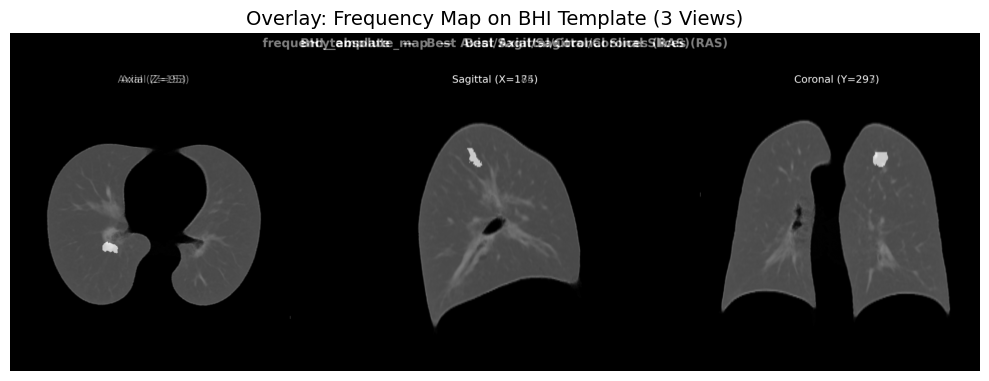

💾 Saved overlay image: /content/output/overlay_best3views_combined.png


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

template_img_path = "/content/output/BHI_template_best3views_RAS.png"
heatmap_img_path = "/content/output/frequency_absolute_map_best3views_RAS.png"
output_path = "/content/output/overlay_best3views_combined.png"

template = Image.open(template_img_path).convert("RGBA")
heatmap = Image.open(heatmap_img_path).convert("RGBA")

if template.size != heatmap.size:
    heatmap = heatmap.resize(template.size, Image.BILINEAR)

template_np = np.array(template).astype(float) / 255.0
heatmap_np = np.array(heatmap).astype(float) / 255.0

alpha = 0.5
combined = (1 - alpha) * template_np[..., :3] + alpha * heatmap_np[..., :3]

plt.figure(figsize=(10, 6))
plt.imshow(combined)
plt.axis('off')
plt.title("Overlay: Frequency Map on BHI Template (3 Views)", fontsize=14)
plt.tight_layout()
plt.show()

Image.fromarray((combined * 255).astype(np.uint8)).save(output_path)
print(f"💾 Saved overlay image: {output_path}")

